### Reading data (Census pay)

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import mlrose_hiive
except:
     !pip install mlrose-hiive

try:
    from imblearn.under_sampling import RandomUnderSampler 
except:
    !pip install imblearn
        


Names1 = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Result']
data1 = pd.read_csv('adult-all.csv', header=None,  index_col=False, names = Names1)
data1.drop_duplicates(inplace=True)
y=data1['Result']
X= data1[data1.columns[data1.columns != 'Result']]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
data1 = pd.concat([X_res, y_res], axis=1)
data1.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Result
0,36,Private,108320,HS-grad,9,Divorced,Transport-moving,Own-child,White,Male,0,0,40,United-States,<=50K
1,55,Private,28735,HS-grad,9,Divorced,Adm-clerical,Unmarried,Amer-Indian-Eskimo,Female,0,0,45,United-States,<=50K
2,35,Private,538583,11th,7,Separated,Transport-moving,Not-in-family,Black,Male,0,0,40,United-States,<=50K
3,49,Local-gov,53482,Some-college,10,Divorced,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K
4,43,Private,416338,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,0,0,50,United-States,<=50K


### Replacing missing data with most frequent

In [230]:
#------------ replaces the missing values with the most frequent value ---------------
def missing_vals(data1):
    for col in data1.columns:
        if '?' in set(data1[col]):
            print (col)
            print('? values in',col, ":", data1[col].value_counts()['?'])
            data1[col].replace('?', np.nan, inplace=True)
            print('Replacing ? with most frequent:', data1[col].mode().iloc[0])
            data1[col].fillna(data1[col].mode().iloc[0], inplace=True)
            print()
        elif data1[col].isna().any():
            print (col, ": nan values present")
            
            
#---------- takes data and convert columns to categories and stores the mappings in a dict ---- 
def convert_cats_labels(data, columns=None, cats_names_dict={}):
    d1c = pd.DataFrame()
    if columns == None:
        for col in data.columns:
            d1c[col] = data[col].astype('category')
            cats_names_dict[col] = dict(enumerate(d1c[col].cat.categories))
            d1c[col] = d1c[col].cat.codes
    
    else:
        for col in data.columns:
            if col in columns:
                d1c[col] = data[col].astype('category')
                cats_names_dict[col] = dict(enumerate(d1c[col].cat.categories))
                d1c[col] = d1c[col].cat.codes
            else:
                d1c[col] = data[col]
                
    return d1c, cats_names_dict
            
missing_vals(data1)
cols_to_cats_d1 = ['workclass', 'education', 'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'native-country', 'Result']

data1, codes_d1 = convert_cats_labels(data1, columns = cols_to_cats_d1)



workclass
? values in workclass : 1053
Replacing ? with most frequent: Private

occupation
? values in occupation : 1056
Replacing ? with most frequent: Exec-managerial

native-country
? values in native-country : 398
Replacing ? with most frequent: United-States



### Train test split 70-30

In [231]:
from sklearn.model_selection import train_test_split
    
X_data1 = data1[data1.columns[data1.columns != 'Result']]
y_data1 = data1.loc[:, 'Result']


X_train11, X_test1, y_train1, y_test = train_test_split(X_data1, y_data1, test_size=0.3, random_state=38)
X_train1, X_val1, y_train, y_val = train_test_split(X_train11, y_train1, test_size=0.1, random_state=38)
print("shape for data1 => training:", X_train1.shape, " and testing:", X_test1.shape, "and validation", X_val.shape)

shape for data1 => training: (14717, 14)  and testing: (7009, 14) and validation (1636, 14)


### Scaling the data for neural networks

In [232]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train1, y_train1)

x_scaled1 = scaler.transform(X_train1)
X_train = pd.DataFrame(x_scaled1, columns=X_train1.columns)

xval_scaled1 = scaler.transform(X_val1)
X_val = pd.DataFrame(xval_scaled1, columns=X_train1.columns)

xtest_scaled1 = scaler.transform(X_test1)
X_test = pd.DataFrame(xtest_scaled1, columns=X_train1.columns)

### Neural network experiments
Testing with different randomized optimized searching\
-wall clock times \
-Function evaluations\
-Accuracy

#### Gradient descent (baseline)

Train time:  3.3090531826019287
Train score: 0.8157233131752395
Validation score: 0.8300733496332519
Testing score: 0.8069624768155229


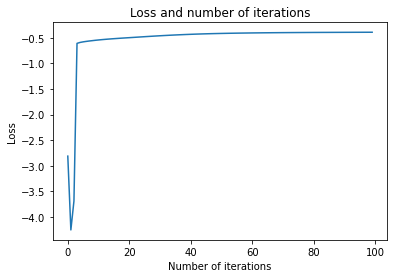

In [395]:
wall_times = {}
fe = {}
accs = {}

def test_with_params(param_to_vary='', param_range=[], on_test = False):
    iters_time = []
    iters_tr_accs = []
    iters_tst_accs = []

    if param_to_vary == '':
        
        nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='gradient_descent', max_attempts=25,
                                           learning_rate = 0.0001) 
        s = time.time()
        nn_model1.fit(X_train, y_train)
        e = time.time()
        train_time = e-s
        print("Train time: ", train_time)
        iters_time.append(train_time)
        wall_times['gd'] = train_time
        trs = nn_model1.score(X_train, y_train)
        tst = nn_model1.score(X_val, y_val)
        print("Train score:",trs)
        print("Validation score:",tst)
        if on_test == True:
            testing = nn_model1.score(X_test, y_test)
            print("Testing score:",testing)
            accs['gd'] = testing
        fe['gd'] = len(nn_model1.fitness_curve)
        iters_tr_accs.append(trs)
        iters_tst_accs.append(tst)
        plt.title('Loss and number of iterations')
        plt.xlabel('Number of iterations')
        plt.ylabel('Loss')
        plt.plot(nn_model1.fitness_curve, label='Loss')
        plt.show()
        return

        
    elif param_to_vary == 'learning_rate':        
        for i in param_range:
                nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm =gd, max_attempts=50,
                                           learning_rate = i)
                s = time.time()
                nn_model1.fit(X_train, y_train)
                e = time.time()
                train_time = e-s
                print("Train time: ", train_time)
                iters_time.append(train_time)

                trs = nn_model1.score(X_train, y_train)
                tst = nn_model1.score(X_val, y_val)
#                 print("Train score:",trs)
#                 print("Test score:",tst)
                iters_tr_accs.append(trs)
                iters_tst_accs.append(tst)
        
    fig, axs = plt.subplots(1,2)   
    print(param_range, iters_tr_accs, iters_tst_accs)
    axs[0].plot(param_range, iters_tr_accs,  label='train accuracy')
    axs[0].plot(param_range, iters_tst_accs,  label='Validation accuracy')
    axs[0].legend()
    if param_to_vary == 'learning_rate':
        for i, v in zip(param_range, iters_tst_accs):
            axs[0].text(i+0.00000002 , v + 0.0001, str(i))
    axs[1].plot(param_range, iters_time, label='Train time')
    axs[1].legend()

    
    plt.show()

test_with_params(on_test=True)

# test_with_params('learning_rate', [0.00005, 0.00009, 0.0001])

# 
# Train time:  35.56697058677673
# Train score: 0.8223822789970782
# Test score: 0.8142388357825653
      # double iterations
# Train time:  63.33968663215637
# Train score: 0.8259835564313379
# Test score: 0.8150948780139821


#### Random hill climb

Train time:  115.7757956981659
Train score: 0.7304477814772032
Validation score: 0.7273838630806846
Testing score: 0.7125124839492082
loss 0.6096570496488326


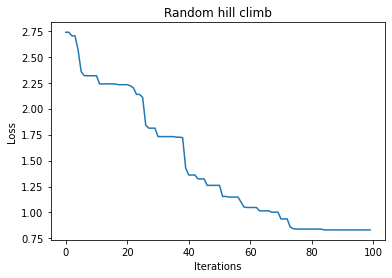

In [397]:
import time
iters_time = []
iters_tr_accs = []
iters_tst_accs = []

learning_rates = [0.01, 0.1, 1, 10]

def test_with_params(param_to_vary='', param_range=[], on_test=False):
    iters_time = []
    iters_tr_accs = []
    iters_tst_accs = []

    if param_to_vary == '':
        nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='random_hill_climb', max_attempts=25,
                                            learning_rate =2,  restarts=50 )
        s = time.time()
        nn_model1.fit(X_train, y_train)
        e = time.time()
        train_time = e-s
        print("Train time: ", train_time)
        iters_time.append(train_time)
        wall_times['rhc'] = train_time
        fe['rhc'] = nn_model1.fitness_curve[-1,1]
        
        trs = nn_model1.score(X_train, y_train)
        tst = nn_model1.score(X_val, y_val)
        print("Train score:",trs)
        print("Validation score:",tst)
        if on_test == True:
            testing = nn_model1.score(X_test, y_test)
            print("Testing score:",testing)
            accs['rhc'] = testing
        print("loss", nn_model1.loss)
        iters_tr_accs.append(trs)
        iters_tst_accs.append(tst)
        
        plt.plot(nn_model1.fitness_curve[:,0], label='Loss')
        plt.title('Random hill climb')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()
        return
                
    elif param_to_vary == 'restarts':
        for i in param_range:
                nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='random_hill_climb', 
                                           learning_rate = 1,  restarts=25)
                s = time.time()
                nn_model1.fit(X_train, y_train)
                e = time.time()
                train_time = e-s
                print("Train time: ", train_time)
                iters_time.append(train_time)

                trs = nn_model1.score(X_train, y_train)
                tst = nn_model1.score(X_val, y_val)
#                 print("Train score:",trs)
#                 print("Test score:",tst)
                iters_tr_accs.append(trs)
                iters_tst_accs.append(tst)
        
    elif param_to_vary == 'learning_rate':        
        for i in param_range:
                nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='random_hill_climb',
                                           learning_rate = i,  restarts=25, max_attempts=10)
                s = time.time()
                nn_model1.fit(X_train, y_train)
                e = time.time()
                train_time = e-s
                print("Train time: ", train_time)
                iters_time.append(train_time)

                trs = nn_model1.score(X_train, y_train)
                tst = nn_model1.score(X_val, y_val)
#                 print("Train score:",trs)
#                 print("Test score:",tst)
                iters_tr_accs.append(trs)
                iters_tst_accs.append(tst)
                
    fig, axs = plt.subplots(1,2)   
    axs[0].plot(param_range, iters_tr_accs,  label='train accuracy')
    axs[0].plot(param_range, iters_tst_accs,  label='Validation accuracy')
    axs[0].legend()
    if param_to_vary == 'learning_rate':
        for i, v in zip(param_range, iters_tst_accs):
            axs[0].text(i+0.2 , v + 0.01, str(i))
    axs[1].plot(param_range, iters_time, label='Train time')
    axs[1].legend()

    
    plt.show()

test_with_params(on_test=True)
# test_with_params('restarts', [5, 10, 15, 30, 50, 70, 90, 100])
# test_with_params('learning_rate', [0.01, 0.1, 1,2,3, 5, 10])

# 0.7332
  
# Test score: 0.710 restarts=5, lr=1 restarts =100

# Train time:  335.1998682022095 rs=200
# Train score: 0.664401712305497
# Test score: 0.6575831074333001
# restarts=100 acc .675  0.6318621595904
# restarts = 50 acc 0.6487

# Train time:  863.8292093276978
# Train score: 0.7210029217911259
# Test score: 0.7127978313596804
# loss 0.5711679834772457
# below for 500 iters
# Train time:  1919.580412387848
# Train score: 0.7210029217911259
# Test score: 0.7127978313596804
# loss 0.5711679834772457


#### Simulated Annealing

Train time:  1.3041517734527588
Train score: 0.6696337568797989
Validation score: 0.6803178484107579
Testing score: 0.671279783135968
loss 1.5288302712507487


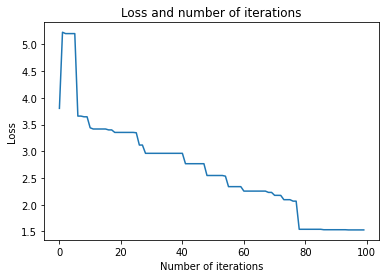

In [388]:
#------------------------- simulated annealing ---------------------

# ad = mlrose_hiive.ArithDecay(init_temp=1.0, decay=0.01, min_temp=0.0001)
# ed=mlrose_hiive.ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.0001)

def test_with_params(param_to_vary='', param_range=[], on_test = False):
    iters_time = []
    iters_tr_accs = []
    iters_tst_accs = []

    if param_to_vary == '':
        gd=mlrose_hiive.GeomDecay(init_temp=5, decay=0.6, min_temp=0.0001)
        nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='simulated_annealing', 
                                           learning_rate = 10,schedule= gd, max_attempts=50 )
        s = time.time()
        nn_model1.fit(X_train, y_train)
        e = time.time()
        train_time = e-s
        print("Train time: ", train_time)
        iters_time.append(train_time)
        
        wall_times['sa'] = train_time
        fe['sa'] = nn_model1.fitness_curve[-1,1]
        
        trs = nn_model1.score(X_train, y_train)
        tst = nn_model1.score(X_val, y_val)
        print("Train score:",trs)
        print("Validation score:",tst)
        
        if on_test == True:
            testing = nn_model1.score(X_test, y_test)
            print("Testing score:",testing)
            accs['sa'] = testing
        print("loss", nn_model1.loss)
        iters_tr_accs.append(trs)
        iters_tst_accs.append(tst)
        plt.title('Loss and number of iterations')
        plt.xlabel('Number of iterations')
        plt.ylabel('Loss')
        plt.plot(nn_model1.fitness_curve[:,0], label='Loss')
        plt.show()
        return
                
    elif param_to_vary == 'schedule':
        for i in param_range:
                nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='simulated_annealing', 
                                           learning_rate = 10, max_attempts=100, 
                                           schedule=mlrose_hiive.GeomDecay(init_temp=5, decay=i, min_temp=0.0001))
                s = time.time()
                nn_model1.fit(X_train, y_train)
                e = time.time()
                train_time = e-s
                print("Train time: ", train_time)
                iters_time.append(train_time)

                trs = nn_model1.score(X_train, y_train)
                tst = nn_model1.score(X_val, y_val)
                print("Train score:",trs)
                print("Test score:",tst)
                iters_tr_accs.append(trs)
                iters_tst_accs.append(tst)
    
    elif param_to_vary == 'init_temp':
        for i in param_range:
                nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='simulated_annealing', 
                                           learning_rate = 10, max_attempts=50, 
                                           schedule=mlrose_hiive.GeomDecay(init_temp=i, decay=0.7, min_temp=0.0001))
                s = time.time()
                nn_model1.fit(X_train, y_train)
                e = time.time()
                train_time = e-s
                print("Train time: ", train_time)
                iters_time.append(train_time)

                trs = nn_model1.score(X_train, y_train)
                tst = nn_model1.score(X_val, y_val)
                print("Train score:",trs)
                print("Test score:",tst)
                iters_tr_accs.append(trs)
                iters_tst_accs.append(tst)
    elif param_to_vary == 'learning_rate':       
        gd=mlrose_hiive.GeomDecay(init_temp=2, decay=0.6, min_temp=0.0001)
        for i in param_range:
                nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='simulated_annealing', max_attempts=50,
                                           learning_rate = i,  schedule=gd)
                s = time.time()
                nn_model1.fit(X_train, y_train)
                e = time.time()
                train_time = e-s
                print("Train time: ", train_time)
                iters_time.append(train_time)

                trs = nn_model1.score(X_train, y_train)
                tst = nn_model1.score(X_val, y_val)
#                 print("Train score:",trs)
#                 print("Test score:",tst)
                iters_tr_accs.append(trs)
                iters_tst_accs.append(tst)
                
    fig, axs = plt.subplots(1,2)   
    axs[0].plot(param_range, iters_tr_accs,  label='train accuracy')
    axs[0].plot(param_range, iters_tst_accs,  label='Validation accuracy')
    axs[0].legend()
    if param_to_vary == 'learning_rate':
        for i, v in zip(param_range, iters_tst_accs):
            axs[0].text(i+0.2 , v + 0.01, str(i))
    axs[1].plot(param_range, iters_time, label='Train time')
    axs[1].legend()

    
    plt.show()

decay_params = [0.2, 0.4, 0.6, 0.75, 0.9, 0.99]
test_with_params(on_test = True)
# test_with_params('init_temp', [ 1, 2, 4, 5, 6])
# test_with_params('schedule', decay_params)
# test_with_params('learning_rate', [ 0.1, 1,5, 10,15, 18, 20, 50,100])


#### Genetic algorithms

Train time:  197.31122303009033
Train score: 0.7829041244818917
Validation score: 0.7830073349633252
Testing score: 0.7752889142531032


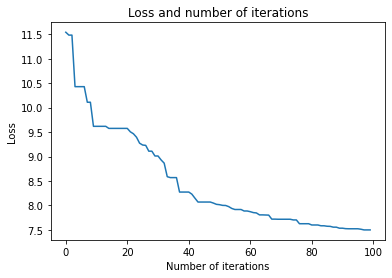

In [392]:
#------------------------- genetic algo ----------


def test_with_params(param_to_vary='', param_range=[], on_test = False):
    iters_time = []
    iters_tr_accs = []
    iters_tst_accs = []

    if param_to_vary == '':
        nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='genetic_alg',  pop_size=150,
                                           mutation_prob=0.001, max_attempts=50, learning_rate = 1)
        s = time.time()
        nn_model1.fit(X_train, y_train)
        e = time.time()
        train_time = e-s
        print("Train time: ", train_time)
        iters_time.append(train_time)
        
        wall_times['ga'] = train_time
        fe['ga'] = sum(nn_model1.fitness_curve[-1,1])

        trs = nn_model1.score(X_train, y_train)
        tst = nn_model1.score(X_val, y_val)
        print("Train score:",trs)
        print("Validation score:",tst)
        
        if on_test == True:
            testing = nn_model1.score(X_test, y_test)
            print("Testing score:",testing)
            accs['ga'] = testing
            
        iters_tr_accs.append(trs)
        iters_tst_accs.append(tst)
        plt.title('Loss and number of iterations')
        plt.xlabel('Number of iterations')
        plt.ylabel('Loss')
        plt.plot(nn_model1.fitness_curve[:,0], label='Loss')
        plt.show()
        return
                
    elif param_to_vary == 'pop':
        for i in param_range:
                nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='genetic_alg', pop_size=i,
                                           mutation_prob=0.001,
                                           learning_rate = 1,  max_attempts = 10)
                s = time.time()
                nn_model1.fit(X_train, y_train)
                e = time.time()
                train_time = e-s
                print("Train time: ", train_time)
                iters_time.append(train_time)

                trs = nn_model1.score(X_train, y_train)
                tst = nn_model1.score(X_val, y_val)
#                 print("Train score:",trs)
#                 print("Test score:",tst)
                iters_tr_accs.append(trs)
                iters_tst_accs.append(tst)
        
                  
    elif param_to_vary == 'mutation':
        for i in param_range:
                nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='genetic_alg', pop_size=100,
                                           mutation_prob=i,
                                           learning_rate = 0.1,  max_attempts = 10)
                s = time.time()
                nn_model1.fit(X_train, y_train)
                e = time.time()
                train_time = e-s
                print("Train time: ", train_time)
                iters_time.append(train_time)

                trs = nn_model1.score(X_train, y_train)
                tst = nn_model1.score(X_val, y_val)
#                 print("Train score:",trs)
#                 print("Test score:",tst)
                iters_tr_accs.append(trs)
                iters_tst_accs.append(tst)
        
        
    elif param_to_vary == 'learning_rate':        
        for i in param_range:
                nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='genetic_alg', pop_size = 150,
                                           learning_rate = i,  mutation_prob=0.001)
                s = time.time()
                nn_model1.fit(X_train, y_train)
                e = time.time()
                train_time = e-s
                print("Train time: ", train_time)
                iters_time.append(train_time)

                trs = nn_model1.score(X_train, y_train)
                tst = nn_model1.score(X_val, y_val)
#                 print("Train score:",trs)
#                 print("Test score:",tst)
                iters_tr_accs.append(trs)
                iters_tst_accs.append(tst)
                
    fig, axs = plt.subplots(1,2)   
    axs[0].plot(param_range, iters_tr_accs,  label='train accuracy')
    axs[0].plot(param_range, iters_tst_accs,  label='Validation accuracy')
    axs[0].legend()
    if param_to_vary == 'learning_rate' or param_to_vary == 'mutation':
        for i, v in zip(param_range, iters_tst_accs):
            axs[0].text(i+0.000002 , v + 0.000001, str(i))
    axs[1].plot(param_range, iters_time, label='Train time')
    axs[1].legend()
    plt.show()

# mutation_range =[0, 0.0001, 0.001, 0.01, 0.1]
# pop_range = [95, 100,150,175, ]

#learning rate makes very little difference
test_with_params(on_test=True)
# test_with_params('pop', pop_range)
# test_with_params('mutation', mutation_range)
# test_with_params('learning_rate', [0.01, 0.1, 1, 5])


In [ ]:
##Final models

nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='gradient_descent', max_attempts=50,
                                           learning_rate = 0.0001) 

gd=mlrose_hiive.GeomDecay(init_temp=5, decay=0.6, min_temp=0.0001)
nn_sa = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='simulated_annealing', 
                                           learning_rate = 10,schedule= gd, max_attempts=50 )

nn_ga = mlrose_hiive.NeuralNetwork(hidden_nodes = [10, 15], activation ='relu', bias = True, 
                                           is_classifier = True, early_stopping = True,random_state = 15, 
                                           curve =True,  algorithm ='genetic_alg',  pop_size=150,
                                           mutation_prob=0.001, max_attempts=50, learning_rate = 1)


In [398]:
fe

{'gd': 100, 'rhc': 6781.0}

In [394]:
wall_times


{'gd': 2.7127861976623535,
 'rhc': 85.54700493812561,
 'sa': 1.3041517734527588,
 'ga': 197.31122303009033}